In [53]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [54]:
biomass_density = pd.read_csv('preprocessed/forecasted.csv')

In [55]:
distance_matrix = pd.read_csv('dataset/Distance_Matrix.csv')

In [56]:
distance_matrix = distance_matrix.drop('Unnamed: 0',axis=1)

In [57]:
biomass_density = biomass_density.drop('Unnamed: 0',axis=1)

In [58]:
distance_matrix.shape

(2418, 2418)

## Prprocessing

In [59]:
#new_distance = lambda den,dist: den/dist

In [60]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233


In [61]:
distance_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,113.4309,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,111.1832,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,111.7859,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,82.5852,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,65.1442,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


## Modelling

In [62]:
year = '2018'

### Get initial point with most density of biomass

In [63]:
def get_most(column_name):
    density=biomass_density[column_name]
    return np.argmax(density)
    

### Get pobability based on biomass density

In [64]:
k=10

In [65]:
def set_prob_depots(density):
    sum_density=sum(density)
    prob=[x/sum_density for x in density]
    return prob

In [66]:
weights=set_prob_depots(biomass_density[year])

In [67]:
def get_depots(k,year,weights):
    depots=[]
    while len(depots)!=k :
        depots = np.random.choice(biomass_density[year].shape[0],size=k,p=weights)
    return list(depots)

In [68]:
biomass_density[year].shape[0]

2418

In [69]:
depots = get_depots(k,year,weights)

### Visualising Data

In [18]:
def plot_depots(depots,clusters=None,refineries=None):
    depots_location = biomass_density.loc[depots, ["Latitude", "Longitude"]]

    latitudes = biomass_density["Latitude"]
    longitudes = biomass_density["Longitude"]

    # Create a scatter plot
    plt.scatter(latitudes, longitudes,c=clusters)
    if(refineries!=None):
        refineries_location = biomass_density.loc[refineries, ["Latitude", "Longitude"]]
        plt.scatter(refineries_location['Latitude'],refineries_location['Longitude'],marker='o', color='white')
    
    plt.scatter(depots_location["Latitude"], depots_location["Longitude"], marker='x', color='red')

    # Add a title and labels
    plt.title('Latitude and Longitude')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    # Show the plot
    plt.show()

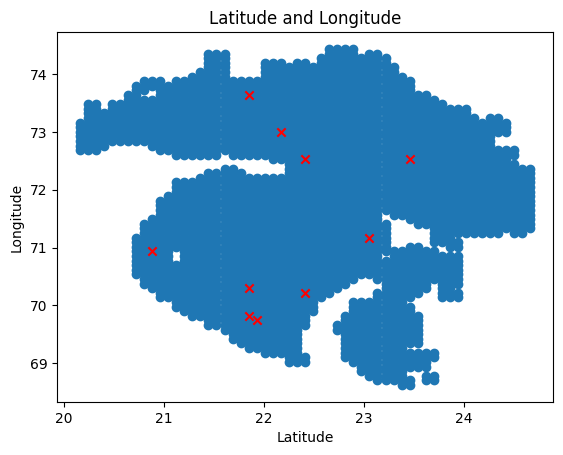

In [19]:
plot_depots(depots)

## Optimal clusters for depots

In [21]:
def re_cluster_depots(k,X,depots):
    belonging_to_cluster=np.array([])
    for i in range(X.shape[0]):
        distance=[distance_matrix.iloc[i,x] for x in depots]
        belonging_to_cluster=np.append(belonging_to_cluster,np.argmin(distance))

    depots = []
    for i in range(k):
        if len(X[belonging_to_cluster==i][['Latitude','Longitude']]) != 0:
            pseudo_coord = np.mean(X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy(),axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy()]
            depots.append(X[belonging_to_cluster==i].iloc[np.argmin(distance),:].name)
        else:
            depots = get_depots(k,year,weights)
            re_cluster_depots(k,X,depots)
        
    return depots,belonging_to_cluster

In [22]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[1943, 2126, 1901, 724, 1503, 1347, 1294, 303, 1800, 1259]
[2190, 2128, 1960, 592, 1442, 1279, 1182, 262, 1801, 1262]
[2190, 2083, 2066, 528, 1504, 1220, 1127, 261, 1801, 1149]
[2190, 2034, 2115, 647, 1505, 1165, 1127, 219, 1747, 923]
[2190, 2034, 2161, 645, 1505, 1110, 1128, 219, 1694, 794]
[2189, 1980, 2162, 645, 1506, 1056, 1074, 180, 1639, 728]
[2189, 1980, 2162, 645, 1567, 1056, 1074, 180, 1581, 662]
[2189, 1980, 2163, 645, 1567, 1057, 1074, 180, 1520, 662]
[2189, 1980, 2163, 645, 1567, 1002, 1074, 180, 1459, 600]
[2189, 1923, 2163, 645, 1567, 940, 1074, 180, 1396, 421]
[2189, 1923, 2118, 645, 1567, 940, 1074, 181, 1330, 422]
[2189, 1923, 2118, 645, 1567, 940, 1074, 181, 1264, 422]
[2189, 1923, 2071, 645, 1567, 940, 1074, 181, 1205, 372]
[2189, 1923, 2071, 645, 1567, 941, 1074, 181, 1150, 325]
Convergence in : 14 iterations


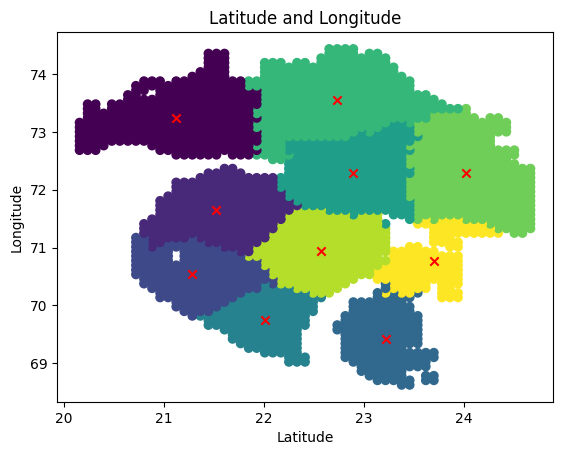

In [23]:
plot_depots(depots,clusters)

## Finding refineries

In [24]:
biomass_density

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233
...,...,...,...,...,...,...,...,...,...,...,...,...
2413,20.15456,72.84432,0.180534,0.180260,0.170496,0.129193,0.180347,0.190154,0.231986,0.181932,0.177813,0.534950
2414,20.15456,72.92394,0.051700,0.054713,0.048782,0.044817,0.051860,0.054145,0.065674,0.051462,0.048789,0.564789
2415,20.15456,73.00357,0.035414,0.037422,0.033379,0.030625,0.035525,0.037108,0.044995,0.035245,0.034098,0.564997
2416,20.15456,73.08319,0.145447,0.121111,0.097915,0.099246,0.114721,0.119751,0.145269,0.113851,0.120770,0.528472


In [25]:
def biomass_per_depot(k,clusters,year):
    biomass=[]
    for i in range(k):
        biomass.append(sum(biomass_density[clusters==i][year]))
    return biomass

In [26]:
biomass_per_depot=biomass_per_depot(k,clusters,year)
biomass_per_depot

[133.3101022649999,
 153.66640004899995,
 113.64711460999995,
 40.04877364029997,
 69.62271082399998,
 151.6877938799999,
 159.78197004199995,
 155.90810414099994,
 164.07852785000003,
 33.142147842]

In [27]:
depots

[2189, 1923, 2071, 645, 1567, 941, 1074, 181, 1150, 325]

In [28]:
r=5

In [29]:
def set_prob_ref(density):
    sum_density = sum(density)
    prob = [x/sum_density for x in density]
    return prob

In [30]:
weights=set_prob_ref(biomass_per_depot)
weights

[0.11346567650277851,
 0.13079175352102407,
 0.09672970407133202,
 0.03408714806301918,
 0.0592587347048832,
 0.12910768094374944,
 0.13599696508913506,
 0.1326997594935362,
 0.13965394104245724,
 0.028208636568085033]

In [31]:
def get_refineries(r,depots,weights):
    if len(weights)<r:
        r = len(weights)
    refineries_index = np.random.choice(len(weights),size=r,p=weights)
    refineries = []
    for i in refineries_index:
        refineries.append(depots[i])
    return refineries

In [32]:
refineries = get_refineries(r,depots,weights)
refineries

[2189, 1923, 1074, 2189, 1567]

## Optimal clusters for refineries

In [33]:
def re_cluster_refineries(r,X,refineries):
    belonging_to_cluster=np.array([])
    for i in X:
        distance = [distance_matrix.iloc[i,x] for x in refineries]
        belonging_to_cluster = np.append(belonging_to_cluster,np.argmin(distance))
        
    X=np.array(X)
    refineries = []
    for i in range(r):
        if len(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy()) != 0:
            pseudo_coord = np.mean(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy(), axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in biomass_density.iloc[:,[0,1]].to_numpy()]
            refineries.append(biomass_density.iloc[np.argmin(distance),:].name)
        else:
            refineries = get_refineries(r,depots,weights)
            re_cluster_refineries(r,X,refineries)
    return refineries,belonging_to_cluster

In [34]:
count=0
clusters_depots=[]
for _ in range(30):
    prev=refineries
    refineries,cluster_depots=re_cluster_refineries(r,depots,refineries)
    if np.array_equal(prev,refineries):
        break
    print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

[2071, 1923, 1150, 2189, 1923, 854]
[1923, 1923, 2189, 2071, 941]
[181, 181, 941, 1074, 2071, 2189, 1634, 604]
[2189, 1923, 1074, 1150, 1074, 941, 1074, 1973]
[2071, 2189, 2071, 1567, 1074]
[1923, 1074, 2071, 2071, 2071, 854, 683]
[1567, 941, 2189, 2189, 1074]
[181, 2189, 1150, 1567, 2071, 1074]
[492, 2189, 657, 1567, 1973]
[683, 2189, 657, 1567, 1973]
Convergence in : 10 iterations


In [35]:
def biomass_per_refineries(r,cluster_depots,biomass_per_depot):
    biomass=[]
    biomass_per_depot=np.array(biomass_per_depot)
    for i in range(r):
        biomass.append(sum(biomass_per_depot[cluster_depots==i]))
    return biomass

In [36]:
biomass_per_refinery = biomass_per_refineries(r,cluster_depots,biomass_per_depot)

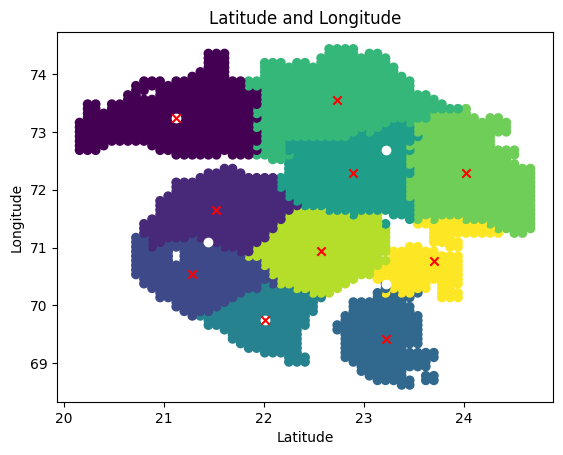

In [37]:
plot_depots(depots,clusters,refineries)

## Loss function for depots

In [38]:
biomass_per_depot

[133.3101022649999,
 153.66640004899995,
 113.64711460999995,
 40.04877364029997,
 69.62271082399998,
 151.6877938799999,
 159.78197004199995,
 155.90810414099994,
 164.07852785000003,
 33.142147842]

In [39]:
biomass_per_refinery

[467.3778680629998,
 133.3101022649999,
 237.26944933229998,
 69.62271082399998,
 267.3135146589999]

In [40]:
clusters

array([7., 7., 7., ..., 0., 0., 0.])

In [41]:
cluster_depots

array([1., 4., 4., 2., 3., 0., 0., 0., 2., 2.])

In [42]:
depots

[2189, 1923, 2071, 645, 1567, 941, 1074, 181, 1150, 325]

In [43]:
refineries

[683, 2189, 657, 1567, 1973]

In [44]:
def loss_depot(depots,year):
    loss=[]
    for i in range(len(depots)):
        loss.append(sum([biomass_density.loc[x,year]*distance_matrix.iloc[x,depots[i]] for x in biomass_density[clusters==i].index]))
    #print(loss)
    return sum(loss)

In [45]:
def loss_refinery(refineries,cluster_depots,depots):
    loss=[]
    refineries=np.array(refineries)
    depots = np.array(depots)
    for i in range(len(refineries)):
        loss.append(sum([biomass_per_depot[x]*distance_matrix.iloc[depots[x],refineries[i]] for x in np.where(depots[cluster_depots==i])[0]]))
    #print(loss)
    return sum(loss)

In [46]:
loss_depot(depots,year)

86608.67301942305

In [47]:
loss_refinery(refineries,cluster_depots,depots)

438597.4652941713

## Best number for depots

In [48]:
k=range(1,25)

In [49]:
loss_d=[]
for i in k:
    year = '2018'
    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

Convergence in : 1 iterations
Convergence in : 8 iterations
Convergence in : 5 iterations
Convergence in : 11 iterations
Convergence in : 6 iterations
Convergence in : 16 iterations
Convergence in : 8 iterations
Convergence in : 13 iterations
Convergence in : 8 iterations
Convergence in : 7 iterations
Convergence in : 12 iterations
Convergence in : 30 iterations
Convergence in : 15 iterations
Convergence in : 8 iterations


AttributeError: 'numpy.ndarray' object has no attribute 'append'